In [ ]:
# Calculation
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.integrate import simpson
import os

# Setting
SAMPLING_RATE = 125
DATA_PATH = "archive/eeg_data"
SUBJECTS = ["neo", "palm", "jd", "warm"]

def get_theta_beta_ratio(file_path):
    try:
        df = pd.read_csv(file_path)
        data = df.select_dtypes(include=[np.number]).values

        if len(data.shape) == 1:
            data = data.reshape(-1, 1)

        freqs, psd = welch(data, fs=SAMPLING_RATE, nperseg=SAMPLING_RATE*2, axis=0)

        # Frequency
        theta_band = (4, 8)
        beta_band = (13, 30)

        theta_idx = np.logical_and(freqs >= theta_band[0], freqs <= theta_band[1])
        beta_idx = np.logical_and(freqs >= beta_band[0], freqs <= beta_band[1])

        # Power
        theta_power = simpson(psd[theta_idx], x=freqs[theta_idx], axis=0)
        beta_power = simpson(psd[beta_idx], x=freqs[beta_idx], axis=0)

        # Theta / Beta Ratio
        ratios = theta_power / (beta_power + 1e-6)

        return np.mean(ratios)

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

print(f"{'Name':<10} | {'Files':<5} | {'Avg Theta/Beta Ratio':<20} | {'Risk Assessment'}")
print("-" * 75)

for subject in SUBJECTS:
    subject_folder = os.path.join(DATA_PATH, subject)
    if not os.path.exists(subject_folder):
        print(f"ไม่เจอโฟลเดอร์ของ {subject}")
        continue

    files = [f for f in os.listdir(subject_folder) if f.endswith('.csv')]
    ratios = []

    for file in files:
        file_path = os.path.join(subject_folder, file)
        ratio = get_theta_beta_ratio(file_path)
        if ratio is not None:
            ratios.append(ratio)

    if ratios:
        avg_ratio = np.mean(ratios)
        risk = "HIGH RISK (ADHD?)" if avg_ratio > 0.8 else "Normal"
        print(f"{subject:<10} | {len(ratios):<5} | {avg_ratio:.4f}               | {risk}")
    else:
        print(f"{subject:<10} | 0     | N/A")

print("-" * 75)

Name       | Files | Avg Theta/Beta Ratio | Risk Assessment
---------------------------------------------------------------------------
neo        | 30    | 0.6368               | Normal
palm       | 30    | 0.6242               | Normal
jd         | 30    | 1.2386               | HIGH RISK (ADHD?)
warm       | 30    | 0.9127               | HIGH RISK (ADHD?)
---------------------------------------------------------------------------


Set Random Seed to 42
กำลังประมวลผลข้อมูลและหั่นไฟล์ (Overlapping Window)...

ได้ข้อมูลทั้งหมด: 1090 ตัวอย่าง

เริ่มเทรนโมเดล...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5636 - loss: 0.7572 - val_accuracy: 0.7159 - val_loss: 0.6562
Epoch 2/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5873 - loss: 0.6879 - val_accuracy: 0.7273 - val_loss: 0.6311
Epoch 3/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6635 - loss: 0.6289 - val_accuracy: 0.7159 - val_loss: 0.6043
Epoch 4/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6613 - loss: 0.6232 - val_accuracy: 0.7500 - val_loss: 0.5930
Epoch 5/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6736 - loss: 0.6186 - val_accuracy: 0.7500 - val_loss: 0.5929
Epoch 6/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6857 - loss: 0.6145 - val_accuracy: 0.7727 - val_loss: 0.5803
Epoch 7/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6820 - loss: 0.5761 - val_accuracy: 0.7614 - val_loss: 0.5714
Epoch 8/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6924 - loss: 0.5725 - val_accuracy: 0.7500 - val_loss

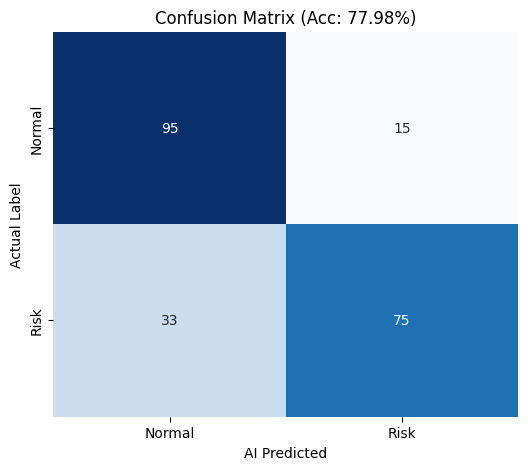

Saved Model to 'adhd_detection_model.h5'
Saved Scaler to 'scaler.pkl'


In [ ]:
# Training and Save model
import pandas as pd
import numpy as np
import os
from scipy.signal import welch
from scipy.integrate import simpson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import random
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import skew, kurtosis

# Seed_setting
SEED_VALUE = 42
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
print(f"Set Random Seed to {SEED_VALUE}")

# Config
SAMPLING_RATE = 125
WINDOW_SIZE_SEC = 4.0
DATA_PATH = "archive/eeg_data"

LABELS = {
    "neo": 0, "palm": 0, "jd": 1, "warm": 1
}

def extract_features_from_window(window_data):
    # Band_Power
    freqs, psd = welch(window_data, fs=SAMPLING_RATE, nperseg=len(window_data), axis=0)
    bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}

    features = []
    for band_name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        power = simpson(psd[idx], x=freqs[idx], axis=0)
        features.append(np.mean(power))

    #Ratio
    theta_beta_ratio = features[1] / (features[3] + 1e-6)
    features.append(theta_beta_ratio)

    # Statistical
    std_val = np.std(window_data)
    ptp_val = np.ptp(window_data)

    features.append(std_val)
    features.append(ptp_val)

    features.append(skew(window_data.flatten()))
    features.append(kurtosis(window_data.flatten()))

    return features

def load_and_process_data():
    X = []
    y = []
    print("กำลังประมวลผลข้อมูลและหั่นไฟล์ (Overlapping Window)...")

    for subject, label in LABELS.items():
        subject_folder = os.path.join(DATA_PATH, subject)
        if not os.path.exists(subject_folder): continue

        files = [f for f in os.listdir(subject_folder) if f.endswith('.csv')]
        for file in files:
            try:
                df = pd.read_csv(os.path.join(subject_folder, file))
                data = df.select_dtypes(include=[np.number]).values

                # Overlapping Logic
                samples_per_window = int(SAMPLING_RATE * WINDOW_SIZE_SEC)
                step_size = int(samples_per_window * 0.5)

                for start in range(0, len(data) - samples_per_window, step_size):
                    end = start + samples_per_window
                    window = data[start:end]

                    # Error_checking
                    if len(window) == samples_per_window:
                        feats = extract_features_from_window(window)
                        X.append(feats)
                        y.append(label)

            except Exception as e:
                print(f"Error file {file}: {e}")

    return np.array(X), np.array(y)

# Load_data
X, y = load_and_process_data()
print(f"\nได้ข้อมูลทั้งหมด: {len(X)} ตัวอย่าง")

# Split_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build_model
model = Sequential([
    Dense(64, input_dim=9, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),

    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train
print("\nเริ่มเทรนโมเดล...")
history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_split=0.1, verbose=1)

# Evaluate_and_ploting
print("\n--- ผลการทดสอบ (Evaluation) ---")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)
print("\nReport:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Risk']))

# Plot_graph
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Risk'],
            yticklabels=['Normal', 'Risk'])
plt.xlabel('AI Predicted')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Acc: {accuracy*100:.2f}%)')
plt.show()

# Save_neural_network
model.save('adhd_detection_model.h5')
print("Saved Model to 'adhd_detection_model.h5'")

# Save_scalar
joblib.dump(scaler, 'scaler.pkl')
print("Saved Scaler to 'scaler.pkl'")

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
from scipy.signal import welch
from scipy.integrate import simpson
from scipy.stats import skew, kurtosis
from tensorflow.keras.models import load_model

# ==========================================
# 1. ตั้งค่า (Config)
# ==========================================
SAMPLING_RATE = 125     # ต้องตรงกับตอนเทรน
WINDOW_SIZE_SEC = 4.0   # ต้องตรงกับตอนเทรน

# โหลดโมเดลและ Scaler ที่เซฟไว้
print("⏳ Loading AI System...")
try:
    model = load_model('adhd_detection_model.h5')
    scaler = joblib.load('scaler.pkl')
    print("✅ System Ready!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# ==========================================
# 2. ฟังก์ชันสกัดฟีเจอร์ (Engine) - 9 Features
# ==========================================
def extract_features(window_data):
    # 1. Band Power (4 features)
    freqs, psd = welch(window_data, fs=SAMPLING_RATE, nperseg=len(window_data), axis=0)
    bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}

    features = []
    for band_name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        power = simpson(psd[idx], x=freqs[idx], axis=0)
        features.append(np.mean(power))

    # 2. Ratio (1 feature)
    theta_beta_ratio = features[1] / (features[3] + 1e-6)
    features.append(theta_beta_ratio)

    # 3. Basic Stats (2 features)
    features.append(np.std(window_data))
    features.append(np.ptp(window_data))

    # 4. Advanced Stats (2 features)
    features.append(skew(window_data.flatten()))
    features.append(kurtosis(window_data.flatten()))

    return features # รวม 9 features

def analyze_eeg_file(file_path):
    print(f"\n📂 Analyzing file: {os.path.basename(file_path)}...")
    try:
        df = pd.read_csv(file_path)
        data = df.select_dtypes(include=[np.number]).values

        # Windowing Process
        samples_per_window = int(SAMPLING_RATE * WINDOW_SIZE_SEC)
        step_size = int(samples_per_window * 0.5)

        X_new = []
        for start in range(0, len(data) - samples_per_window, step_size):
            end = start + samples_per_window
            window = data[start:end]
            if len(window) == samples_per_window:
                X_new.append(extract_features(window))

        if not X_new:
            return "❌ File too short or empty"

        # เตรียมข้อมูลส่งให้ AI
        X_new = np.array(X_new)
        X_new_scaled = scaler.transform(X_new) # ปรับสเกล

        # ให้ AI ทำนายทีละท่อน (Segment)
        predictions = model.predict(X_new_scaled, verbose=0)

        # สรุปผล (Voting)
        risk_segments = np.sum(predictions > 0.5)
        total_segments = len(predictions)
        risk_probability = (risk_segments / total_segments) * 100

        # แสดงผลลัพธ์
        print("-" * 40)
        print(f"📊 Analysis Result:")
        print(f"   - Total Segments Scanned: {total_segments}")
        print(f"   - Segments Classified as Risk: {risk_segments}")
        print(f"   - ADHD Probability Score: {risk_probability:.2f}%")
        print("-" * 40)

        # เกณฑ์ตัดสิน (Threshold)
        if risk_probability > 50:
            return "🔴 RESULT: HIGH RISK (ADHD Tendency Detected)"
        else:
            return "🟢 RESULT: NORMAL (Within Normal Range)"

    except Exception as e:
        return f"❌ Error analyzing file: {e}"

# ==========================================
# 3. พื้นที่ทดสอบ (Test Zone)
# ==========================================
# *** เปลี่ยนชื่อไฟล์ตรงนี้เพื่อทดสอบคนอื่นๆ ***
target_file = "data.csv"
final_result = analyze_eeg_file(target_file)
print(f"\n{final_result}\n")

⏳ Loading AI System...
✅ System Ready!

📂 Analyzing file: data.csv...
----------------------------------------
📊 Analysis Result:
   - Total Segments Scanned: 9
   - Segments Classified as Risk: 4
   - ADHD Probability Score: 44.44%
----------------------------------------

🟢 RESULT: NORMAL (Within Normal Range)

